In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(data_id=554)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [ ]:
def plot_digits(data,img_size=28, rows=10):
  fig, ax = plt.subplots(rows, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
      if i < data.shape[0]:
        im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
      im.set_clim(0, 16)

In [ ]:
def plot_digits_with_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).item()
          drawColor = 'black'
          if (pred_label>0) != (labels[i]>0.5):
            drawColor = 'red'
          axi.set_title("label:{}\npred:{:1.2f}".format(labels[i],pred_label), color=drawColor)
        im.set_clim(0, 16)

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                   # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss


def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)


def computeLabelAccuracy(model, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = model(data)
      correct += (output>0).eq(target>0).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

class LinearClassifier(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, numClasses)

    def forward(self, x):
        x = x.view(-1,self.flatSize)  #Pytorch will replace -1 with the batch size
        x = self.linear1(x)
        return x

def SigmoidLoss(output, target): #L2 Loss - same as nn.MSELoss()
   loss = torch.mean((torch.sigmoid(output) - target)**2)
   return loss

In [ ]:
mnist_training_data = mnist.data.values[0:60000,:] #Keep the first 60000 samples for training
mnist_training_labels = mnist.target.values[0:60000]
mnist_testing_data = mnist.data.values[60000:,:] #Test on the rest
mnist_testing_labels = mnist.target.values[60000:]

In [ ]:
selected_labels = ['3', '7', '8']
mask = np.isin(mnist_training_labels, selected_labels)

lucky_data = mnist_training_data[mask]
unlucky_data = mnist_training_data[~mask]

In [ ]:

testing_mask = np.isin(mnist_testing_labels, selected_labels)

In [ ]:
num_lucky = lucky_data.shape[0]
balanced_data = np.vstack((lucky_data,unlucky_data[0:num_lucky]))
balanced_labels = np.append(np.ones(num_lucky), (np.zeros(num_lucky)))
balanced_labels = np.expand_dims(1.0*(balanced_labels), 1)
balanced_labels.shape

(36494, 1)

In [ ]:
training_dataset = NumpyDataset(np.array(balanced_data),balanced_labels)
testing_dataset = NumpyDataset(mnist_testing_data,testing_mask.astype(float))

Loaded Data
Epoch [1/30], Train Loss: 0.2039, Test Loss: 0.4592
Epoch [6/30], Train Loss: 0.1584, Test Loss: 0.4743
Epoch [11/30], Train Loss: 0.1513, Test Loss: 0.4369
Epoch [16/30], Train Loss: 0.1512, Test Loss: 0.4426
Epoch [21/30], Train Loss: 0.1463, Test Loss: 0.4491
Epoch [26/30], Train Loss: 0.1422, Test Loss: 0.4308


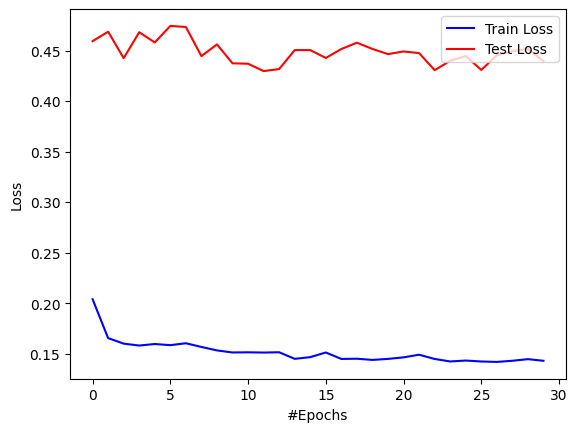

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 100

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = LinearClassifier(image_w, image_h, 1)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = SigmoidLoss #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model, training_generator, "Train Set")
computeLabelAccuracy(model, testing_generator, "Test Set")


Train Set: Accuracy: 31342/36494 (85.9%)

Test Set: Accuracy: 559896/10000 (5599.0%)


AUC: 0.9183835161167958
Precision [0.93298251 0.72873693]
Recall [0.86262164 0.8562417 ]
F1 [0.89642353 0.78736071]
Count [6988 3012]


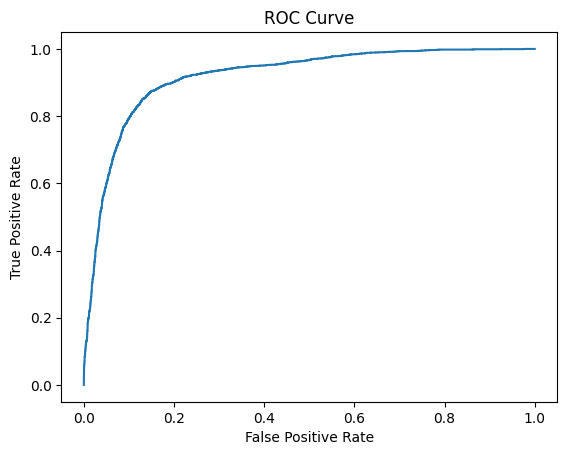

In [ ]:
preds = model(torch.tensor(mnist_testing_data).float()).detach().numpy()
fpr, tpr, thresholds = metrics.roc_curve(testing_mask.astype(float),preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(testing_mask.astype(float),preds>0)
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

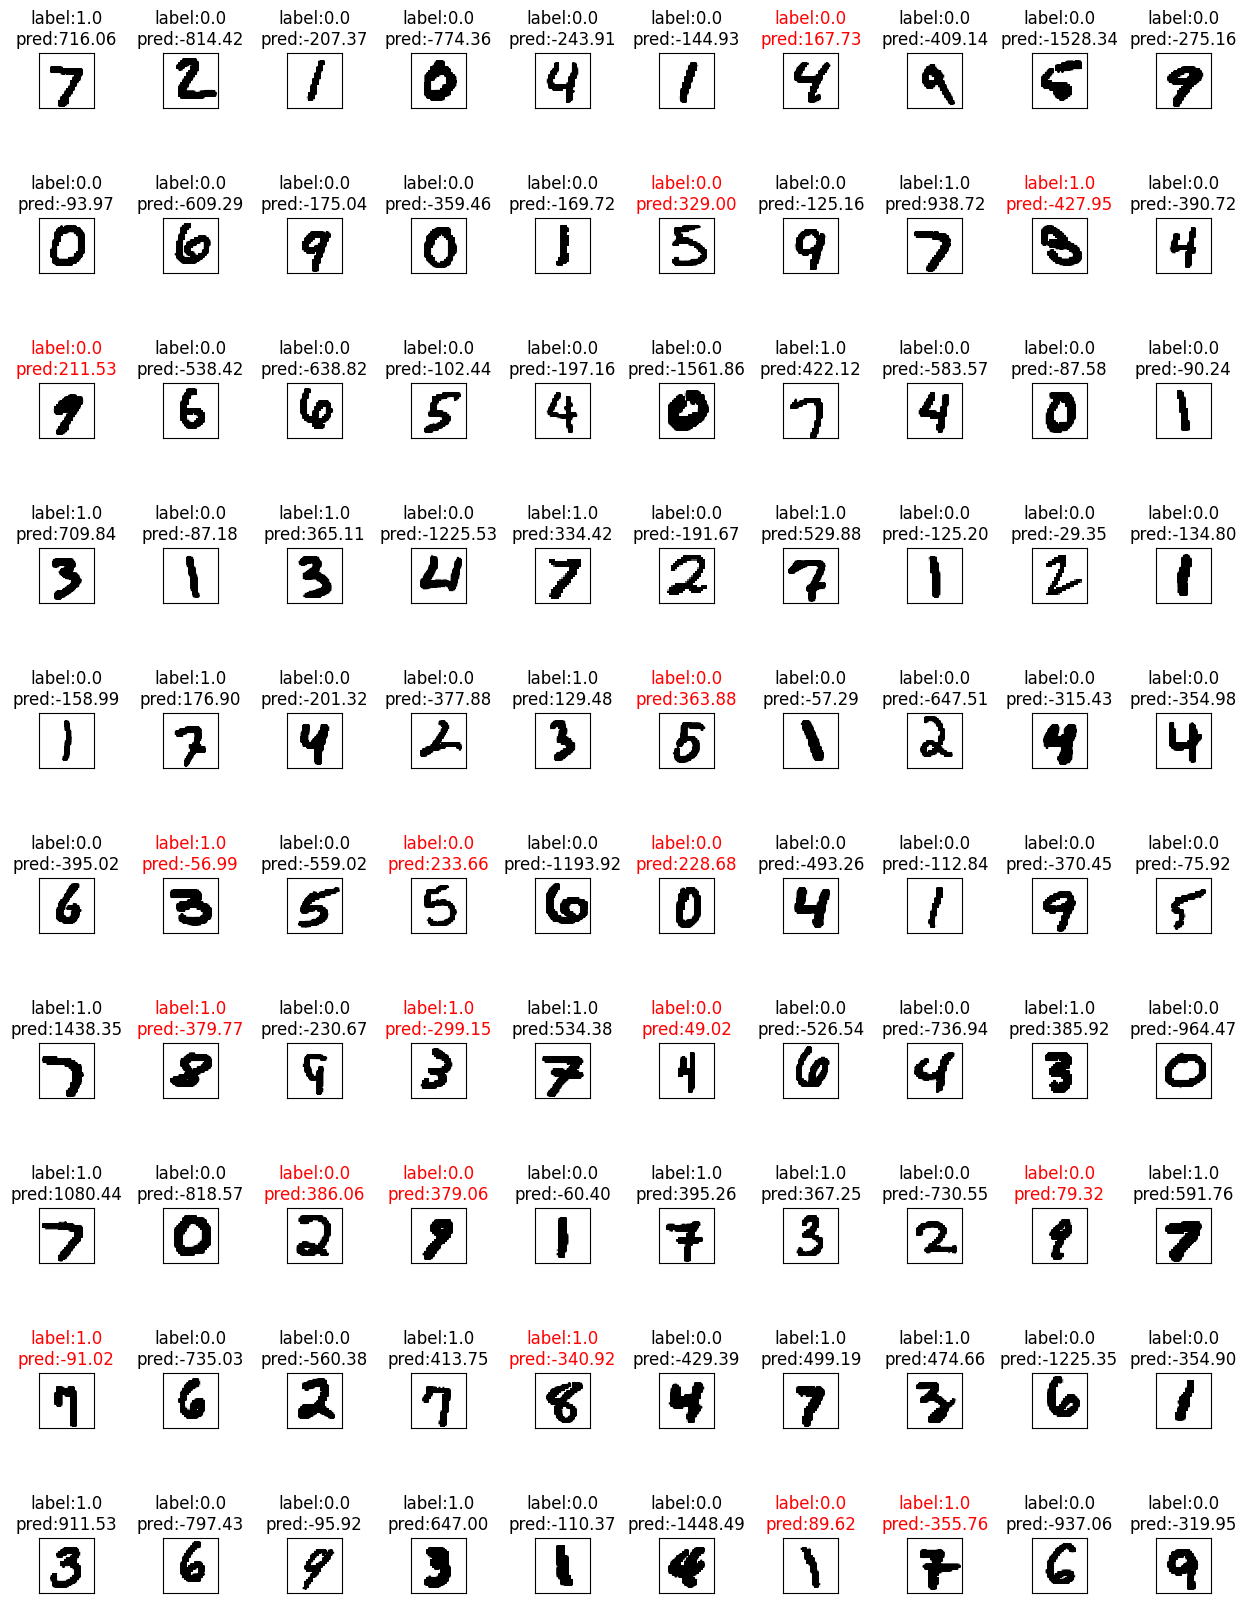

In [ ]:
plot_digits_with_predictions(model,mnist_testing_data,testing_mask.astype(float))

For this method, I created a linear regression classifier with use of the sigmoid loss function. This method worked decently well, with an auc of 0.91 and an f1 score of 0.89.

Not all lucky numbers worked equally well. 3, for example, tends to be mistaken with 8 or 5 more often than 7 or 8 is mistaken.

In [ ]:
# Problem 2

In [ ]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def knn_classifier(X_train, y_train, X_test):
  # instantiate learning model and fit data
  knn = KNeighborsClassifier(n_neighbors=10)
  knn.fit(X_train, y_train)

  # predict the response
  pred = knn.predict(X_test)
  return pred

In [ ]:
def print_scores(y_test,pred):
  accuracy = accuracy_score(y_test, pred)

  fpr, tpr, thresholds = metrics.roc_curve(testing_mask.astype(float),pred > 0)
  plt.plot(fpr,tpr)
  plt.title("ROC Curve")
  print("AUC:",metrics.auc(fpr, tpr))
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  f1 = f1_score(y_test, pred, pos_label=1)
  # print("Reduced Dimensionality: ")
  print("Accuracy: ", accuracy)
  print("F1: ", f1)

In [ ]:
pred = knn_classifier(balanced_data, balanced_labels.ravel(), mnist_testing_data)


AUC: 0.9799167193086079
Accuracy:  0.9817
F1:  0.9697969962039941


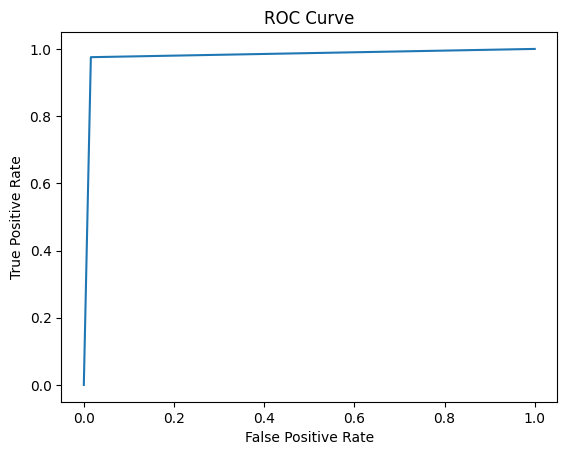

In [ ]:
print_scores(testing_mask.astype(float), pred)

For this model, I decided to use my balanced dataset alongside KNN classifier with k of 10. I chose a k value of 10 because I felt with the size of this dataset 10 neighbors would accurately classify a new image.

 This intuition seemed to be true as my results were suprisingly good. With an accuracy of 98% and f1 score of 0.97, this definitely beats my linear regression classifier. The AUC was also improved going from 0.91 to 0.98

In [ ]:
# Problem 3

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

torch.set_printoptions(sci_mode=False)

In [ ]:
def plot_digits(data,img_size=28, rows=10):
  fig, ax = plt.subplots(rows, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
  fig.subplots_adjust(hspace=0.05, wspace=0.05)
  for i, axi in enumerate(ax.flat):
      if i < data.shape[0]:
        im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
      im.set_clim(0, 16)

def plot_digits_with_mnist_predictions(model, data, labels, img_size=28, rows=10):
    fig, ax = plt.subplots(rows, 10, figsize=(16, 20),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=2.0, wspace=0.01)
    for i, axi in enumerate(ax.flat):
        if i < data.shape[0]:
          im = axi.imshow(data[i].reshape(img_size, img_size), cmap='Greys')
          pred_label = model(torch.tensor(data[i]).float()).max(1, keepdim=True)[1].item()
          true_label = np.argmax(labels[i])
          drawColor = 'black'
          if pred_label != true_label:
            drawColor = 'red'
          axi.set_title("label:{}\npred:{}".format(true_label,pred_label), color=drawColor)
        im.set_clim(0, 16)

In [ ]:
def train(model,  data_generator, loss_function, optimizer):
  model.train() #updates any model layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for i, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = model(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
  return avg_loss/num_batches

def test(model, test_loader, loss_function):
  model.eval() #updates any model layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []

  for epoch in range(num_epochs):
    avg_loss = train(model, training_generator, loss_function, optimizer)
    test_loss = test(model, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      true_labels = target.data.max(1, keepdim=True)[1]
      correct += pred.eq(true_labels.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))

In [ ]:
class NumpyDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, input_array, target_output_array):
    'Initialization'
    self.input_tensor = torch.from_numpy(input_array).float()
    self.output_tensor = torch.from_numpy(target_output_array).float()

  def __len__(self):
      'Denotes the total number of samples'
      return len(self.input_tensor)

  def __getitem__(self, index):
      'Generates one sample of data'
      # Load data and get label
      X = self.input_tensor[index]
      y = self.output_tensor[index]

      return X, y

In [ ]:
mnist_training_labels_categories = F.one_hot(torch.Tensor(torch.Tensor(mnist_training_labels.to_numpy().astype(int))).long()).numpy()
mnist_testing_labels_categories = F.one_hot(torch.Tensor(torch.Tensor(mnist_testing_labels.to_numpy().astype(int))).long()).numpy()

In [ ]:
training_dataset = NumpyDataset(mnist_training_data,mnist_training_labels_categories)
testing_dataset = NumpyDataset(mnist_testing_data,mnist_testing_labels_categories)

In [ ]:
class Classifier_3Layers(nn.Module):
    def __init__(self, img_w, img_h, numClasses):  #For binary predictions numClasses = 1 is fine
        super().__init__()
        self.flatSize = img_w*img_h
        self.img_w = img_w
        self.img_h = img_h
        self.linear1 = nn.Linear(self.flatSize, 20)  #Multiple matrix "layers"
        self.linear2 = nn.Linear(20, 15)             #This is 784->20->15->10 ...
        self.linear3 = nn.Linear(15, numClasses)     #... try different options

    def forward(self, x):
        x = x.view(-1,self.flatSize)   #Pytorch will replace -1 with the batch size
        x = torch.abs(self.linear1(x)) # "abs" and/or "relu" are example of non-linear tranformations
        x = F.relu(self.linear2(x))    # 'relu' keeps positive numbers same, sets negative numbers to 0
        x = self.linear3(x)
        return x

Loaded Data
Epoch [1/30], Train Loss: 1.0659, Test Loss: 0.4101
Epoch [6/30], Train Loss: 0.1631, Test Loss: 0.1874
Epoch [11/30], Train Loss: 0.1132, Test Loss: 0.1693
Epoch [16/30], Train Loss: 0.0992, Test Loss: 0.1873
Epoch [21/30], Train Loss: 0.0868, Test Loss: 0.1770
Epoch [26/30], Train Loss: 0.0809, Test Loss: 0.1888


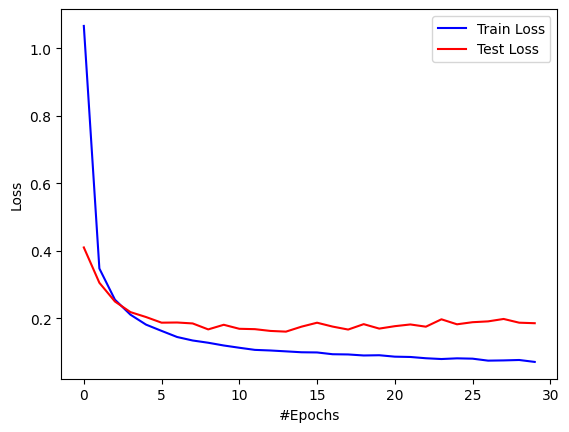

In [ ]:
#Training parameters
num_epochs = 30
print_interval = 5
learning_rate = 0.001
batch_size = 200

#MNIST images are 28x28
image_w = 28
image_h = 28

#Create model
predModel = Classifier_3Layers(image_w, image_h, 10)

#Set optimizer and loss function
model = predModel;
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #or torch.optim.SGD
loss_function = nn.CrossEntropyLoss() #torch.nn.MSELoss() #Try the built-in MSELoss, it should be identical


#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")

trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

In [ ]:
computeLabelAccuracy(model, training_generator, "Test Set")
computeLabelAccuracy(model, testing_generator, "Train Set")


Test Set: Accuracy: 59010/60000 (98.3%)

Train Set: Accuracy: 9591/10000 (95.9%)


Text(70.72222222222221, 0.5, 'Predicted Class')

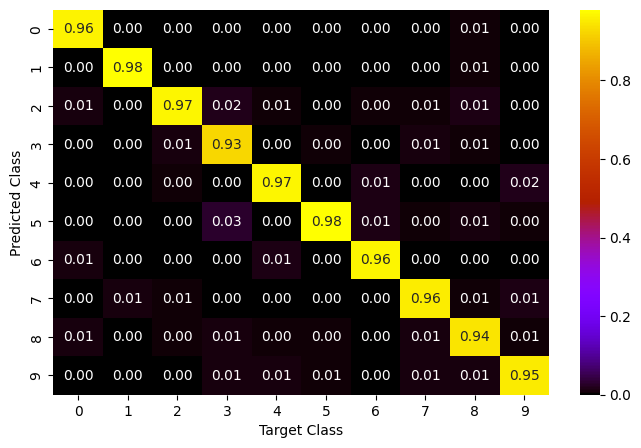

In [ ]:
data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=10000)
data_enumerator = enumerate(data_generator)
_, (images,labels) = next(data_enumerator)
with torch.no_grad():
    pred_catigories = model(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
    true_labels = labels.data.max(1, keepdim=True)[1]
conf_mat = confusion_matrix(true_labels.numpy(), pred_labels.numpy(), normalize = "pred")
plt.figure(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt="0.2f", cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
plt.xlabel("Target Class")
plt.ylabel("Predicted Class")

This model uses an unbalanced dataset, and utilizes one hot encoding to find the softmax for each prediction. The classifier is a 3 layer neural network going from node sizes 784->20->15->10, 10 being the number of classes.

The accuracy was 95.9% on test data, which is the highest seen so far. When testing with a single layer NN, the accuracy was in the 80s.

In [ ]:
# Problem 4

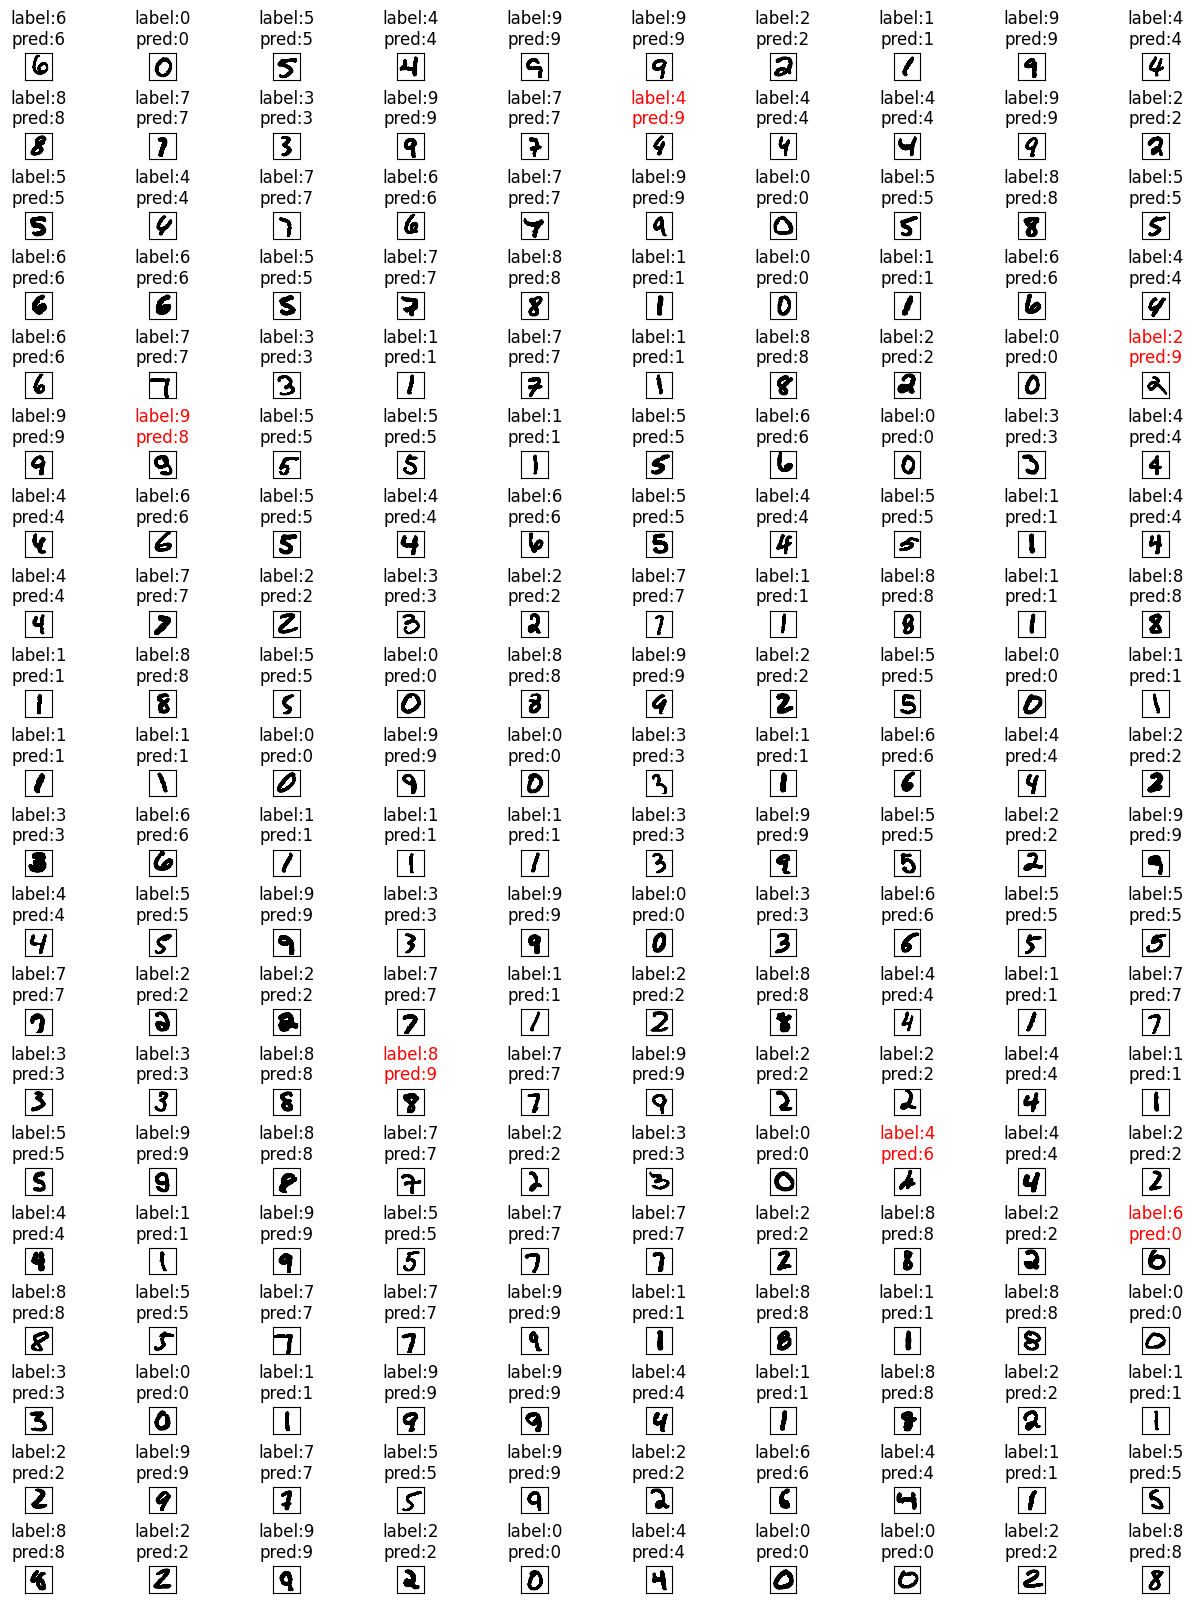

In [ ]:
plot_digits_with_mnist_predictions(model, mnist_testing_data[100:], mnist_testing_labels_categories[100:],rows=20)

Most commonly mistaken digits:
1. 3 mistaken for 5
2. 3 mistaken for 2
3. 9 mistaken for 4
4. 7 mistaken for 9
5. 8 mistaken for 9

